In [1]:
import torch 
import gpytorch
import config_safeopt as cfg
from GPTrainer import GPTrainer
import math
import gp_config as gp_cfg    
train_x = cfg.INITIAL_X
train_y = cfg.INITIAL_Y
%load_ext autoreload 
%autoreload 2
gp_trainer = GPTrainer(gp_cfg, train_x, train_y)

C_lower = torch.full_like(cfg.DOMAIN.flatten(), -float('inf'))
C_upper = torch.full_like(cfg.DOMAIN.flatten(), float('inf'))
C_lower[cfg.INITIAL_SAFE_INDICES] = cfg.SAFETY_THRESHOLD
    
S_mask = torch.zeros(cfg.N_POINTS, dtype=torch.bool)
S_mask[cfg.INITIAL_SAFE_INDICES] = True
    
# Pre-compute pairwise distances for the discrete domain D
distance_matrix = torch.cdist(cfg.DOMAIN, cfg.DOMAIN) 



In [2]:
i = 0

In [7]:
print("l_scale --" ,gp_trainer.model.covar_module.base_kernel.lengthscale.item())
print("output scale  -- " ,gp_trainer.model.covar_module.outputscale)

gp_trainer.train()
print("l_scale --" ,gp_trainer.model.covar_module.base_kernel.lengthscale.item())
print("output scale  -- " ,gp_trainer.model.covar_module.outputscale)
# get posterior mean and std 
gp_trainer.model.eval()
gp_trainer.likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    posterior = gp_trainer.likelihood(gp_trainer.model(cfg.DOMAIN))
    mean = posterior.mean
    std_dev = posterior.stddev

Q_lower = mean - math.sqrt(cfg.BETA) * std_dev
Q_upper = mean + math.sqrt(cfg.BETA) * std_dev

C_lower = torch.max(C_lower, Q_lower) 
C_upper = torch.min(C_upper,Q_upper)

S_prev_indices = torch.where(S_mask)[0]
new_S_mask = S_mask.clone()
for s_idx in S_prev_indices:
    # set of indicies for all points that are lipschitz safe relative to x[s_idx]
    lipschitz_safe = C_lower[s_idx] - cfg.LIPSCHITZ_CONSTANT * distance_matrix[s_idx] >= cfg.SAFETY_THRESHOLD
    new_S_mask = torch.logical_or(new_S_mask, lipschitz_safe)
S_mask = new_S_mask

if not torch.any(S_mask):
    print(f"Iteration {i+1}: Safe set is empty. Stopping.")
    

wt_D = C_upper - C_lower
wt_S = torch.full_like(wt_D, -1e9)
wt_S[S_mask] = wt_D[S_mask]

xt = cfg.DOMAIN[torch.argmax(wt_S)]
yt = cfg.ground_truth(xt) + torch.randn(1) * 0.2 # 

print (train_y.shape, yt.unsqueeze(0).shape , yt.shape)
train_x = torch.cat([train_x, xt.unsqueeze(0)])
train_y = torch.cat([train_y, yt])


print(f"Final train set size : {len(train_x)} \n Final safe set = {torch.where(S_mask)[0].tolist()}")

l_scale -- 0.7981370687484741
output scale  --  tensor(0.5981, grad_fn=<SoftplusBackward0>)
Iter 1/50 - Loss: 1.082   noise: 0.598   L_scale: 0.798
l_scale -- 0.9093040227890015
output scale  --  tensor(0.5171, grad_fn=<SoftplusBackward0>)
torch.Size([3]) torch.Size([1, 1]) torch.Size([1])
Final train set size : 4 
 Final safe set = [4, 5]


In [4]:
# mean
# gp_trainer.model.train_inputs
# gp_trainer.model.train_
gp_trainer.model.covar_module.outputscale


tensor(0.5981, grad_fn=<SoftplusBackward0>)

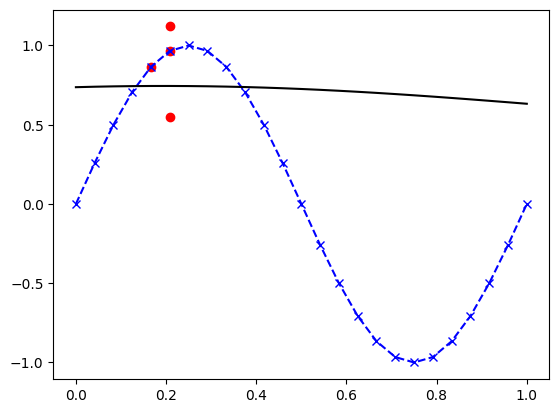

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_x.numpy(), train_y.numpy(), 'ro', label='Training Data')
plt.plot(cfg.DOMAIN.numpy(), cfg.ground_truth(cfg.DOMAIN).numpy(), 'bx--', label='Ground Truth')
plt.plot(cfg.DOMAIN.numpy(), mean.numpy(), 'k-', label='GP Mean')


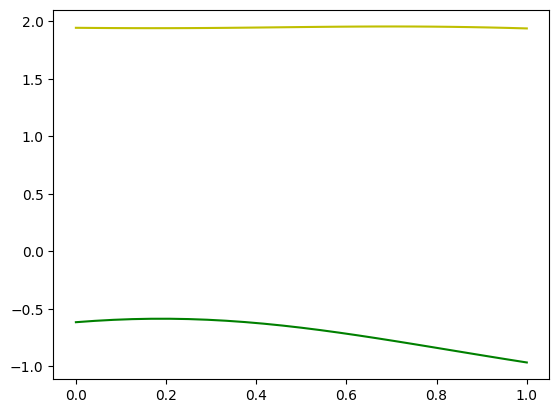

In [6]:
plt.plot(cfg.DOMAIN.numpy(), Q_lower.numpy(), 'g-', label='C lower bound')
plt.plot(cfg.DOMAIN.numpy(), Q_upper.numpy(), 'y-', label='C upper bound')